# Instacart Data Science Challenge
Jamie Liu

### Major Steps:
* Import Data
* Adjust to Local Timezone
* Data Cleaning
    * Check NULL values
    * Check if/where duplicate records exist
* Feature Extraction
* EDA
    * Explore data to get basic insights
    * Time of day analysis on deliveries
    * Day of week analysis on deliveries
    * Most common problems with orders
* Deep Dives and Recommendations
    * Issue Type vs. Rating: What Upsets Customers The Most?
    * Make assumptions and calculate Issue-Ticket Ratio: 85%
    * Map out peak hours as guidance for customer service reps on work shifts planning

In [1046]:
from datetime import datetime
import pytz
from dateutil import tz
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

## Import Data

In [1047]:
path = os.getcwd()
ins = pd.read_csv(path+'/ins.csv')

In [1048]:
ins.head(3)

,order delivery time,order id,customer order rating,type of issue reported,region
0,2014-06-02 04:23:16 UTC,233599337,5,NaN,chi
1,2014-06-02 03:57:50 UTC,233599376,5,NaN,chi
2,2014-06-02 02:52:38 UTC,233599328,5,NaN,chi


## Adjust to Local Timezone

In [1049]:
chi = ins[ins['region'].str.strip() == 'chi']
sf = ins[ins['region'].str.strip() == 'sf']
nyc = ins[ins['region'].str.strip() == 'nyc']

sf['region'] = sf['region'].str.strip()
sf['order delivery time'] = [x.replace("+0000","UTC") for x in sf['order delivery time']]

chi['order delivery time'] = pd.to_datetime(chi['order delivery time'])
nyc['order delivery time'] = pd.to_datetime(nyc['order delivery time'])
sf['order delivery time'] = pd.to_datetime(sf['order delivery time'])

chi['order delivery time']=chi['order delivery time'].dt.tz_localize('utc').dt.tz_convert('America/Chicago')
sf['order delivery time']=sf['order delivery time'].dt.tz_localize('utc').dt.tz_convert('US/Pacific')
nyc['order delivery time']=nyc['order delivery time'].dt.tz_localize('utc').dt.tz_convert('America/New_York')

chi['order delivery time'] = chi['order delivery time'].astype(str).str[:-6]
sf['order delivery time'] = sf['order delivery time'].astype(str).str[:-6]
nyc['order delivery time'] = nyc['order delivery time'].astype(str).str[:-6]

In [1050]:
ins = pd.concat([chi, sf, nyc])

## Data Cleaning
### Check null values:
##### Only keep rows with at least 3 non-null values

In [1051]:
ins.dropna(thresh=3)
ins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14957 entries, 0 to 14940
Data columns (total 5 columns):
order delivery time       14957 non-null object
order id                  14957 non-null int64
customer order rating     14957 non-null int64
type of issue reported    1087 non-null object
region                    14957 non-null object
dtypes: int64(2), object(3)
memory usage: 701.1+ KB


##### The above table shows that "types of issue reported" is populated by 7%, meaning ~7% of orders are reported to have problems
##### Interestingly, every order has a customer rating, which is not likely. This could actually indicate that customers who did not rate end up counted as 5-star rating after a while. Therefore, a rating of 5 might not be as accurate/indicative of customer satisfaction as stars 1~4.

### Check if/where duplicate records exist:
##### Discovered duplicate orders (order id, order delivery time)

In [1052]:
ins.nunique()

order delivery time       14600
order id                  13845
customer order rating         6
type of issue reported        7
region                        3
dtype: int64

###### The table above shows 6 unique types of customer ratings instead of 5. This is because there are "0"s as ratings. We will look further in the EDA process later.

In [1053]:
ins['customer order rating'].value_counts()

5    11602
4     1680
3      778
1      373
2      370
0      154
Name: customer order rating, dtype: int64

In [1054]:
oid = ins['order id']
dup = ins[oid.isin(oid[oid.duplicated()])].sort_values(by=['order id'])
dup.head(30)
dup[25:28]

,order delivery time,order id,customer order rating,type of issue reported,region
14112,2014-05-01 11:51:01,220806,1,Damaged or spoiled,sf
14113,2014-05-01 11:51:01,220806,1,Damaged or spoiled,sf
14114,2014-05-01 11:51:01,220806,1,Poor service,sf


##### ~8% of all order ids are duplicate. Some single order (e.g. order id: 220806) has different issue types. Since current app interface doesn’t enable reporting multiple issues, such records will be treated as mis-recorded info and be de-duped. 

##### Duplicate orders with multiple ratings are treated as a case of user's in-app rating correction and therefore are de-duped only by keeping the latest.

In [1055]:
len(ins)

14957

In [1056]:
ins.sort_values('order delivery time', inplace=True) 
ins.drop_duplicates(['order id'], keep='last',inplace=True)

In [1057]:
len(ins)

13845

## Feature Extraction
##### Create a "issue flag" that has 1 for orders with issue and 0 for no issue;
##### Create additional columns "order date", "hour of day", "day of week", "weekday number" and "weekend flag" from "order delivery time"; We also add another variable "time of day" by grouping hours of day into "morning", "afternoon" and "night". Theoretically we could group it using dimension reduction as well, coupling with some meaningful metrics that can explain its variation.

In [1032]:
ins['order delivery time'] = pd.to_datetime(ins['order delivery time'])
ins['order date'] = ins['order delivery time'].dt.date
ins['orders']= 1
ins['day of week'] = ins['order delivery time'].dt.day_name()
ins['hour of day'] = ins['order delivery time'].dt.hour
ins['time of day'] = pd.cut(ins['hour of day'],[0,13,17,24],labels=['Morning & Noon','Afternoon','Night'])
ins['weekday number'] = ins['order delivery time'].dt.dayofweek + 1
ins['weekend flag'] = ins['weekday number'] // 6
ins['type of issue reported'] = ins['type of issue reported'].fillna('No issue')
ins['issue flag'] = (ins['type of issue reported']!='No issue').astype(int)
ins = ins.drop(['order delivery time','order id'],axis=1)
ins.head(3)

,customer order rating,type of issue reported,region,order date,orders,day of week,hour of day,time of day,weekday number,weekend flag,issue flag
14785,2,No issue,sf,2014-05-01,1,Thursday,1,Morning & Noon,4,0,0
14666,3,Poor service,sf,2014-05-01,1,Thursday,2,Morning & Noon,4,0,1
14783,2,Wrong item,sf,2014-05-01,1,Thursday,8,Morning & Noon,4,0,1


## Exploratory Data Analysis
### Explore data to get basic insights:

In [1033]:
ins.describe()

,customer order rating,orders,hour of day,weekday number,weekend flag,issue flag
count,13845.000000,13845.0,13845.000000,13845.000000,13845.000000,13845.000000
mean,4.582232,1.0,15.699025,4.199567,0.345540,0.061972
std,0.968279,0.0,3.749206,2.106106,0.475561,0.241113
min,0.000000,1.0,0.000000,1.000000,0.000000,0.000000
25%,5.000000,1.0,13.000000,2.000000,0.000000,0.000000
50%,5.000000,1.0,16.000000,4.000000,0.000000,0.000000
75%,5.000000,1.0,19.000000,6.000000,1.000000,0.000000
max,5.000000,1.0,23.000000,7.000000,1.000000,1.000000


##### The above table shows that average rating 4.58 is pretty high, with majorly of the orders (at least more than 75% percentiles) having a 5-star rating. But we'll need to break down further to see how it correlates with order problems/issues and other factors. Mean hour of day for delivery is around 4pm, but that might not be the real typical hour for deliveries because this could be the evened-out result from noon and evening peaks. We'll confirm later by plotting it out.

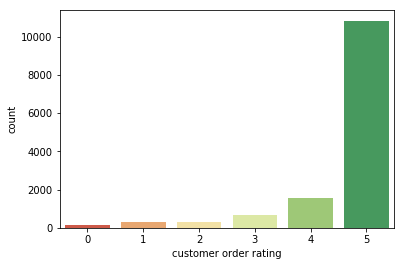

In [1034]:
sns.countplot(x='customer order rating',data=ins,palette='RdYlGn')

##### 0-star ratings are not likely. After breaking it down by issue types, we find very few of them have issue. So we infer that 0 ratings could come out of some mis-coding during data transmission. We can either trim them out or combine them with 5-star ratings since they really look like healthy orders in nature. Here we choose to trim them out since the amount is too low and wouldn't affect the analysis much.

In [1035]:
ins = ins[ins['customer order rating'] != 0]

### Time of Day Analysis on Deliveries:

##### Now we split data by weekend vs weekday to see difference in purchase pattern. Since order placed time is not available, order delivery time will be used as a proxy to infer.

In [1036]:
ins_wknd = ins[(ins['weekend flag']==1)]
ins_wkdy = ins[(ins['weekend flag']==0)]

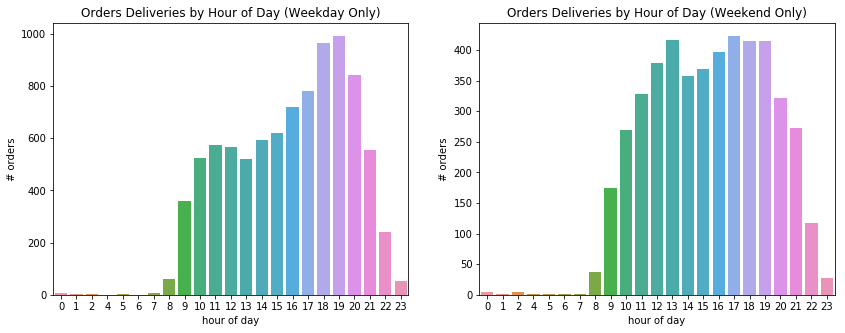

In [1037]:
fig, ax =plt.subplots(1,2,figsize=(14,5))
ax[0]=sns.countplot(x='hour of day',data=ins_wkdy, ax = ax[0])
ax[0].set_title('Orders Deliveries by Hour of Day (Weekday Only)')
ax[0].set(ylabel='# orders')

ax[1]=sns.countplot(x='hour of day',data=ins_wknd,ax=ax[1])
ax[1].set_title('Orders Deliveries by Hour of Day (Weekend Only)')
ax[1].set(ylabel='# orders')

fig.show()

##### It seems that customers love to have their groceries arrived not too early, not too late, but just on time before the cooking start. How do we know? 
##### From the two charts above, we can see that the typical hour of day people have their groceries delivered is 6~7pm on weekday, and 1pm and 5~7pm on weekend. This makes sense because majority of our customers will probably have lunch at work on weekdays and only need groceries delivered around dinner time. On weekend, on the other hand, they may place orders around noon for lunch cooking as well. 

##### It's also clear that on weekdays, our customer typically place orders 2 hours later than they do on weekend. The peak hour for deliveries is 7pm for weekdays vs. 5pm for weekends. This could be because many of them come home later from work and may want to make sure that when the groceries arrive, they can be at home readily to open doors, etc.

### Day of Week Analysis on Deliveries:

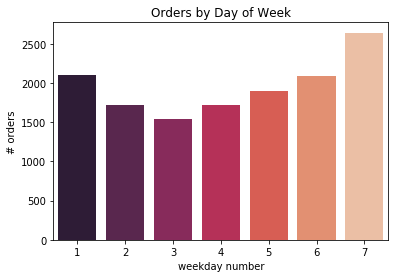

In [1038]:
ax = sns.countplot(x='weekday number',data=ins,palette='rocket')
ax.set_title('Orders by Day of Week')
ax.set(ylabel='# orders')
plt.show()

##### The above chart shows weekly seasonality of orders volume, which presents a weekly recurrent curve with Sunday as peak and Wednesday as trough. We are seeing nearly twice as many orders on Sunday compared to Wednesday.

### Most common problems with orders:

In [1039]:
ins_issue = ins[ins['issue flag']==1]

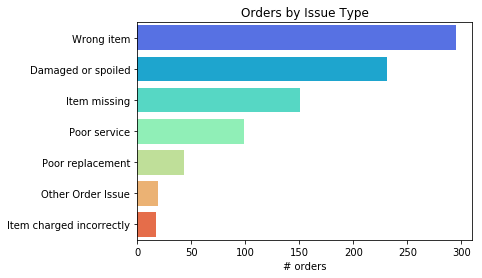

In [1040]:
rnk = ins_issue['type of issue reported'].value_counts()
ax = sns.countplot(y='type of issue reported',data=ins_issue, orient='h',palette='rainbow',order=rnk.index)
ax.set_title('Orders by Issue Type')
ax.set(xlabel='# orders')
ax.set(ylabel='')
plt.show()

##### Among all problems with orders, we see that the highest occurrent is Wrong item, followed by Damanged items. However, more importantly, we want to know what problems upset our customers the most. That is, what problems we need to focus on fixing so that our customers are happier. Therefore, we want to look at correlations between Issue Type and Order Ratings.

## Deep dives and Recommendations
### Issue Type vs. Rating: What Upsets Customers The Most?

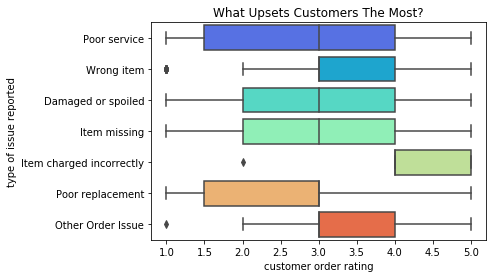

In [1041]:
ax = sns.boxplot(y='type of issue reported',x='customer order rating',data=ins_issue, orient='h', palette='rainbow')
ax.set_title('What Upsets Customers The Most?')
plt.show()

##### It seems that the #1 factor customers value is service. We can see that although wrong/damaged items rank as most commonly reported issues, they are not linked closely with customer satisfaction. The real deal breaker is still service.

### Make assumptions and calculate Issue-Ticket Ratio
##### We assume that with the current in-app setting, reporting certain types of issue will automatically trigger the creation of a ticket in the system, while the remaining types of issue will not. Then, we can use the table below to actually calculate Issue-Ticket Ratio.

In [1042]:
pd.concat([rnk, ins_issue['type of issue reported'].value_counts(normalize=True)],axis=1)

,type of issue reported,type of issue reported
Wrong item,295,0.345029
Damaged or spoiled,231,0.270175
Item missing,151,0.176608
Poor service,99,0.115789
Poor replacement,43,0.050292
Other Order Issue,19,0.022222
Item charged incorrectly,17,0.019883


##### Let's say "Wrong item", "Item missing", "Damaged or spoiled", "Item charged incorrectly" are the four reasons that needs instant examination from a CS rep, while the other types of issue can be subjective and therefore may or may not be easily examined and fixed, so they will not auto-generate tickets unless a customer place one (likelihood = 15%). The formula goes as below:

* Issue-Ticket Ratio = (0.35 + 0.27 + 0.18 + 0.02) x 100% + (0.12 + 0.05 + 0.02) x 15% = 0.85

##### We can conclude that 85% of orders with issue reported will generate a CS ticket.

### Map out peak hours as guidance for customer service reps on work shifts planning

##### Below we trimmed out downtime and only look at deliveries at the prime hours, which is from 9am to 9pm.

In [1043]:
ins_prime = ins[(ins['hour of day']>=9) & (ins['hour of day']<=21)]
ins_issue_prime = ins_issue[(ins_issue['hour of day']>=9) & (ins_issue['hour of day']<=21)]

gp_ins_prime = ins_prime.groupby(['weekday number','hour of day']).sum()[['customer order rating','orders','issue flag']]
gp_ins_prime['problem orders']=gp_ins_prime['issue flag']
gp_ins_prime['sum rating on problem orders'] = ins_issue_prime.groupby(['weekday number','hour of day']).sum()[['customer order rating']]
gp_ins_prime['avg rating']=round(gp_ins_prime['customer order rating']/gp_ins_prime['orders'],2)
gp_ins_prime['avg rating on problem orders'] = round(gp_ins_prime['sum rating on problem orders']/gp_ins_prime['issue flag'],2)
gp_ins_prime['issue rate'] = round(gp_ins_prime['problem orders']/gp_ins_prime['orders'],2)

gp_ins_prime = gp_ins_prime.drop(['customer order rating','sum rating on problem orders','issue flag'],axis=1)

In [1044]:
pv_ords = gp_ins_prime.pivot_table(values='problem orders',index='weekday number',columns='hour of day')
pv_rate = gp_ins_prime.pivot_table(values='issue rate',index='weekday number',columns='hour of day')
pv_rating = gp_ins_prime.pivot_table(values='avg rating on problem orders',index='weekday number',columns='hour of day')

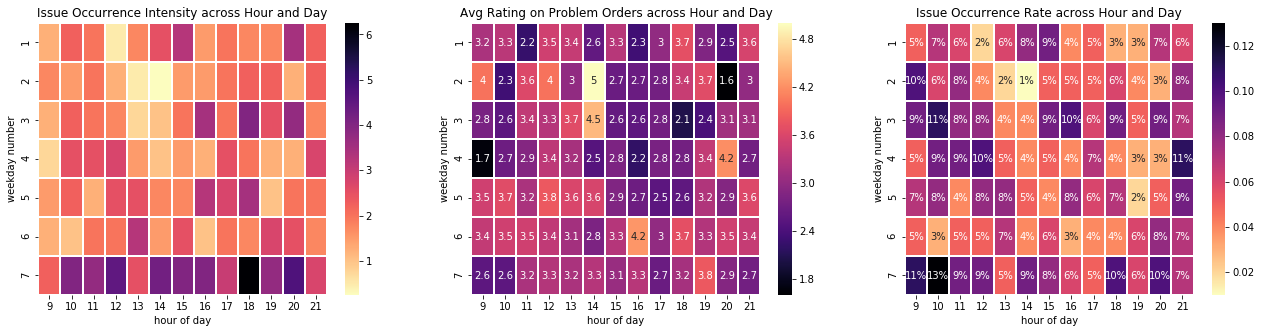

In [1045]:
fig, ax=plt.subplots(1,3,figsize=(22,5))
ax[0] = sns.heatmap(pv_ords/4,cmap='magma_r',fmt='.0f',linecolor='white',linewidths=1, ax= ax[0])
ax[0].set_title('Issue Occurrence Intensity across Hour and Day')
ax[1] = sns.heatmap(pv_rating,cmap='magma',linecolor='white',linewidths=1,annot=True, ax = ax[1])
ax[1].set_title('Avg Rating on Problem Orders across Hour and Day')
ax[2] = sns.heatmap(pv_rate,cmap='magma_r',fmt='.0%',linecolor='white',linewidths=1,annot=True, ax= ax[2])
ax[2].set_title('Issue Occurrence Rate across Hour and Day')
fig.show()

##### We can use the heat maps above to alert Customer Service Reps that at some specific weekday and hour, they can expect to see higher number of issues (heatmap #1), or orders are more likely to go wrong (heatmap #3), or customers are more likely to give very negative ratings (heatmap #2). The three heatmaps are in nature correlated to some extent and can be used together as a good indicator on customer satisfaction and help CS reps to predict and prepare for high call volume.
##### There are some interesting findings we can get from reading the heatmap. For example, 6pm Sunday is the time when more orders go wrong;  
##### Customers tend to give out lower ratings on after-work deliveries in the very middle of the week, Tuesday and Wednesday. This could be associated with stress level of both buyers and shoppers, but we'd have to look at more data to validate; 
##### We want to see more lighter blocks vs. the darker ones. Customer Service Reps should anticipate busiest time around those darkest blocks and adjust their shifts accordingly to meet the needs.